In [2]:
import tkinter as tk
from tkinter import filedialog
import os
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Conv1DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# 符号付に変換する関数
def unsigned2signed(x):
    if x > 32767:
        return x - 65536
    return x

In [6]:
# 学習データの読み込み
def load_binary_data(folder_path):
    data = {}  # ファイルの拡張子と数字を除いたフルパスをキーとしたディクショナリ
    file_names = []  # ファイル名を格納するリスト

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            match = re.match(r'(.+?)\.d(\d+)', file)  # 正規表現で.d○○の形式のファイル名を捉える
            if match:
                file_name, data_index = match.groups()
                data_index = int(data_index)
                full_path = os.path.join(root, file)  # フルパス
                full_path_key = full_path[:-4]  # 拡張子と数字を除いたフルパス
                if full_path_key not in data or data_index > data[full_path_key][8]:
                    with open(full_path, 'rb') as in_file:
                        buf = in_file.read()
                    # 8つのセンサーデータをグループ化
                    sensor_data = [buf[i:i+8*2] for i in range(408, len(buf), 8*2)]
                    sensor_values = []  # センサーデータを格納するリスト
                    for i in range(8):
                        sensor_values.append([unsigned2signed(int.from_bytes(sensor[i*2:i*2+2], 'little')) for sensor in sensor_data])
                    # 拡張子の番号を追加してデータをタプルに格納
                    sensor_values.append(int(data_index))
                    data[full_path_key] = sensor_values  # センサーデータと拡張子の番号をタプルに格納
                    file_names.append(file_name)  # ファイル名をリストに追加

    return data, file_names

# Tkinterを初期化
root = tk.Tk()
root.withdraw()  # メインウィンドウを非表示にする

# フォルダを選択するためのダイアログを表示
folder_selected = filedialog.askdirectory()

if folder_selected:
    print("選択したフォルダ:", folder_selected)
    # フォルダ内のデータを読み込む
    data, data_filenames = load_binary_data(folder_selected)
    if data:
        print("データの読み込みが完了しました。")
    else:
        print("データが見つかりませんでした。")
else:
    print("フォルダが選択されませんでした。")

# Tkinterを終了
root.quit()

sensor_data_dict = {}  # センサーデータを格納するディクショナリ
for key, sensor_data in data.items():
    extension_number = sensor_data[-1]  # 拡張子の番号
    for i, sensor_value in enumerate(sensor_data[:-1]):  # 拡張子の番号を除くセンサーデータをループ
        sensor_key = f"{key}_{extension_number}_{i+1}"  # キーを生成
        if sensor_key not in sensor_data_dict:
            sensor_data_dict[sensor_key] = []  # キーが存在しない場合、空のリストを作成
        sensor_data_dict[sensor_key].append(sensor_value)  # キーに対応するリストにセンサーデータを追加

# データの形状を決定
num_samples = len(sensor_data_dict)
num_sensors = 8  # センサーの数

# 2次元のリストを初期化
data_matrix = [[None] * num_sensors for _ in range(num_samples)]

# センサーデータのみを保存する新しい変数を作成
sensor_data = []

# データを2次元リストと新しい変数に配置
for i, (key, sensor_values) in enumerate(sensor_data_dict.items()):
    data_matrix[i] = [key] + sensor_values  # キーとセンサーデータのリストを1つのリストに格納
    sensor_data.append(sensor_values)  # センサーデータのリストを新しい変数に格納

# data_matrix には各キー（インデックス）に対応するセンサーデータが格納されています
# sensor_data にはセンサーデータのリストのみが格納されています

選択したフォルダ: C:/Users/r-fujita/Desktop/（原）教師データ/FCC_E-2316B
データの読み込みが完了しました。


In [8]:
# テストデータの読み込み
def load_test_data(test_folder_path):
    test_data = {}  # ファイルの拡張子と数字を除いたフルパスをキーとしたディクショナリ
    test_file_names = []  # ファイル名を格納するリスト

    for root, dirs, files in os.walk(test_folder_path):
        for file in files:
            match = re.match(r'(.+?)\.d(\d+)', file)  # 正規表現で.d○○の形式のファイル名を捉える
            if match:
                file_name, data_index = match.groups()
                data_index = int(data_index)
                full_path = os.path.join(root, file)  # フルパス
                full_path_key = full_path[:-4]  # 拡張子と数字を除いたフルパス
                if full_path_key not in test_data or data_index > test_data[full_path_key][8]:
                    with open(full_path, 'rb') as in_file:
                        buf = in_file.read()
                    # 8つのセンサーデータをグループ化
                    sensor_data = [buf[i:i+8*2] for i in range(408, len(buf), 8*2)]
                    sensor_values = []  # センサーデータを格納するリスト
                    for i in range(8):
                        sensor_values.append([unsigned2signed(int.from_bytes(sensor[i*2:i*2+2], 'little')) for sensor in sensor_data])
                    # 拡張子の番号を追加してデータをタプルに格納
                    sensor_values.append(int(data_index))
                    test_data[full_path_key] = sensor_values  # センサーデータと拡張子の番号をタプルに格納
                    test_file_names.append(file_name)  # ファイル名をリストに追加

    return test_data, test_file_names

# Tkinterを初期化
root = tk.Tk()
root.withdraw()  # メインウィンドウを非表示にする

# テストデータのフォルダを選択するためのダイアログを表示
test_folder_path = filedialog.askdirectory()

if test_folder_path:
    print("選択したテストデータのフォルダ:", test_folder_path)
    # テストデータを読み込む
    test_data, test_data_filenames = load_test_data(test_folder_path)
    if test_data:
        print("テストデータの読み込みが完了しました。")
    else:
        print("テストデータが見つかりませんでした.")
else:
    print("テストデータのフォルダが選択されませんでした.")

test_sensor_data_dict = {}  # テストデータのセンサーデータを格納するディクショナリ
for key, test_sensor_data in test_data.items():
    extension_number = test_sensor_data[-1]  # 拡張子の番号
    for i, test_sensor_value in enumerate(test_sensor_data[:-1]):  # 拡張子の番号を除くセンサーデータをループ
        test_sensor_key = f"{key}_{extension_number}_{i+1}"  # キーを生成
        if test_sensor_key not in test_sensor_data_dict:
            test_sensor_data_dict[test_sensor_key] = []  # キーが存在しない場合、空のリストを作成
        test_sensor_data_dict[test_sensor_key].append(test_sensor_value)  # キーに対応するリストにテストデータのセンサーデータを追加

# データの形状を決定
num_test_samples = len(test_sensor_data_dict)
num_sensors = 8  # センサーの数

# テストデータの2次元のリストを初期化
test_data_matrix = [[None] * num_sensors for _ in range(num_test_samples)]

# テストデータのセンサーデータのみを保存する新しい変数を作成
test_sensor_data = []

# テストデータを2次元リストと新しい変数に配置
for i, (key, test_sensor_values) in enumerate(test_sensor_data_dict.items()):
    test_data_matrix[i] = [key] + test_sensor_values  # キーとセンサーデータのリストを1つのリストに格納
    test_sensor_data.append(test_sensor_values)  # テストデータのセンサーデータのリストを新しい変数に格納

# test_data_matrix には各キー（インデックス）に対応するテストデータのセンサーデータが格納されています
# test_sensor_data にはテストデータのセンサーデータのリストのみが格納されています

選択したテストデータのフォルダ: C:/Users/r-fujita/Desktop/（原）教師データ/FCC_E-2316A
テストデータの読み込みが完了しました。


In [10]:
# データの標準化
# 学習データ
sensor_data_sca = []
for i in range(len(sensor_data)):
    mean = np.mean(sensor_data[i])
    std = np.std(sensor_data[i])

    #標準化処理を実行
    standardization_sensor_data = (sensor_data[i] - mean) / std
    sensor_data_sca.append(standardization_sensor_data)

# テストデータ
test_sensor_data_sca = []
for i in range(len(test_sensor_data)):
    mean = np.mean(test_sensor_data[i])
    std = np.std(test_sensor_data[i])

    #標準化処理を実行
    standardization_test_sensor_data = (test_sensor_data[i] - mean) / std
    test_sensor_data_sca.append(standardization_test_sensor_data)


# データ長を揃える
# 最大の波形データ長を見つける
max_length = max(max(len(waveform) for waveform in sensor) for sensor in sensor_data_sca + test_sensor_data_sca)

# ゼロパディングを行う
padded_sensor_data = []
for sensor in sensor_data_sca:
    padded_sensor = []
    for waveform in sensor:
        # ゼロパディング
        padding = [0] * (max_length - len(waveform))
        padded_waveform = np.concatenate((waveform, padding)) if len(padding) > 0 else waveform
        padded_sensor.append(padded_waveform)
    padded_sensor_data.append(padded_sensor)

# 同じことをtest_sensor_dataにも適用
padded_test_sensor_data = []
for sensor in test_sensor_data_sca:
    padded_sensor = []
    for waveform in sensor:
        # ゼロパディング
        padding = [0] * (max_length - len(waveform))
        padded_waveform = np.concatenate((waveform, padding)) if len(padding) > 0 else waveform
        padded_sensor.append(padded_waveform)
    padded_test_sensor_data.append(padded_sensor)

# 学習データとテストデータをNumPyの配列に変換
padded_sensor_data = np.array(padded_sensor_data)
padded_test_sensor_data = np.array(padded_test_sensor_data)

# 中間の次元（次元1）を削除して2次元に reshape
padded_sensor_data = np.squeeze(padded_sensor_data, axis=1)
padded_test_sensor_data = np.squeeze(padded_test_sensor_data, axis=1)

# データ数×データ長×チャンネルの形状に変換
# データ数を8で割ってチャンネル数を8に変換する
#padded_sensor_data = padded_sensor_data.reshape((len(sensor_data)//8, max_length, 8))
#padded_test_sensor_data = padded_test_sensor_data.reshape((len(test_sensor_data)//8, max_length, 8))

In [12]:
def stacked_what_where_autoencoder(input_shape):
    # Encoder
    inputs = Input(shape= input_shape)
    conv1 = Conv1D(32, 3, activation='selu', padding='same')(inputs)
    pool1 = MaxPooling1D(pool_size=2, padding='same')(conv1)  
    conv2 = Conv1D(64, 3, activation='selu', padding='same')(pool1)
    pool2 = MaxPooling1D(pool_size=2, padding='same')(conv2)  

    # Decoder
    #conv3 = Conv1D(64, 3, activation='selu', padding='same')(pool2)
    up1 = UpSampling1D(2)(pool2)
    #up1 = UpSampling1D(2)(conv3)
    conv4 = Conv1DTranspose(32, 3, activation='selu', padding='same')(up1)
    up2 = UpSampling1D(2)(conv4) 
    decoded = Conv1DTranspose(input_shape, 3, activation='selu', padding='same')(up2)

    # Autoencoder Model
    autoencoder = Model(inputs, decoded)
    return autoencoder

In [14]:
# 入力データの形状を取得
input_shape = (max_length,8)
# Stacked What-Where Autoencoderを構築
autoencoder = stacked_what_where_autoencoder(input_shape)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# モデルのサマリを表示
autoencoder.summary()

# モデルの学習
history = autoencoder.fit(padded_sensor_data, padded_sensor_data, epochs=10, batch_size=16, shuffle=True, verbose=1)

TypeError: '<=' not supported between instances of 'tuple' and 'int'

In [24]:
print(input_shape)

(14784, 8)


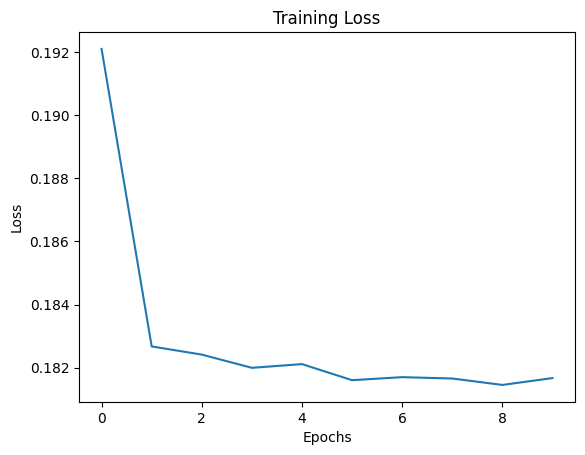

<Figure size 640x480 with 0 Axes>

In [28]:
# 損失関数の値を取得
loss = history.history['loss']

# エポックごとの損失関数の変化をプロット
plt.plot(loss)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# 画像として保存
plt.savefig('training_loss.png')  # 任意のファイル名と拡張子を指定して保存

226/226 [==============================] - 4s 19ms/step


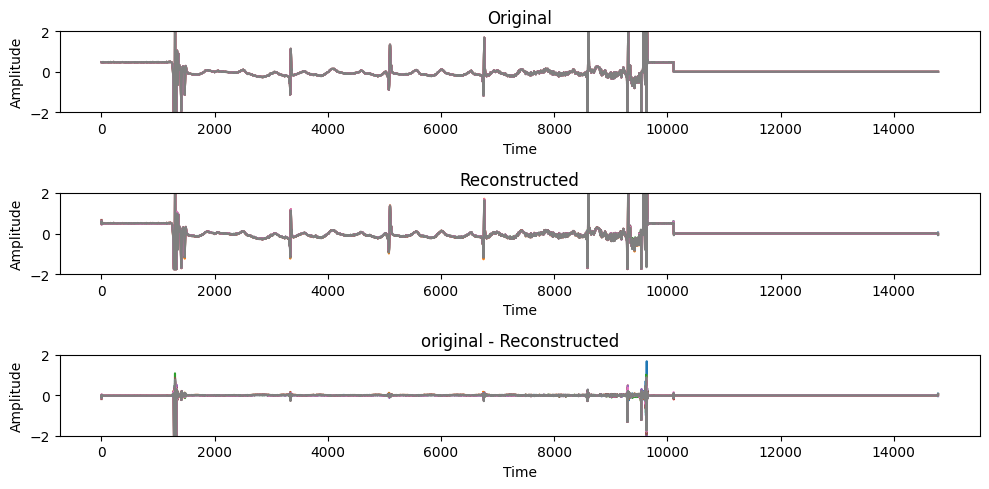

In [30]:
# テストデータを使って再構築を行う
reconstructed_test_data = autoencoder.predict(padded_test_sensor_data)

# いくつかのデータをプロットして可視化
import matplotlib.pyplot as plt

n = 5  # 表示するデータ
plt.figure(figsize=(10, 5))

# オリジナルのデータをプロット
ax = plt.subplot(3, 1, 1)
plt.plot(padded_test_sensor_data[n])
plt.title("Original")
plt.ylim(-2,2)
plt.xlabel('Time')  # x軸ラベル
plt.ylabel('Amplitude')  # y軸ラベル

# 再構築されたデータをプロット
ax = plt.subplot(3, 1, 2)
plt.plot(reconstructed_test_data[n])
plt.title("Reconstructed")
plt.ylim(-2,2)
plt.xlabel('Time')  # x軸ラベル
plt.ylabel('Amplitude')  # y軸ラベル

# オリジナル-再構築
ax = plt.subplot(3, 1, 3)
w = padded_test_sensor_data[n] - reconstructed_test_data[n]
plt.plot(w)
plt.title("original - Reconstructed")
plt.ylim(-2,2)
plt.xlabel('Time')  # x軸ラベル
plt.ylabel('Amplitude')  # y軸ラベル

plt.tight_layout()
plt.show()



211/211 [==============================] - 4s 18ms/step


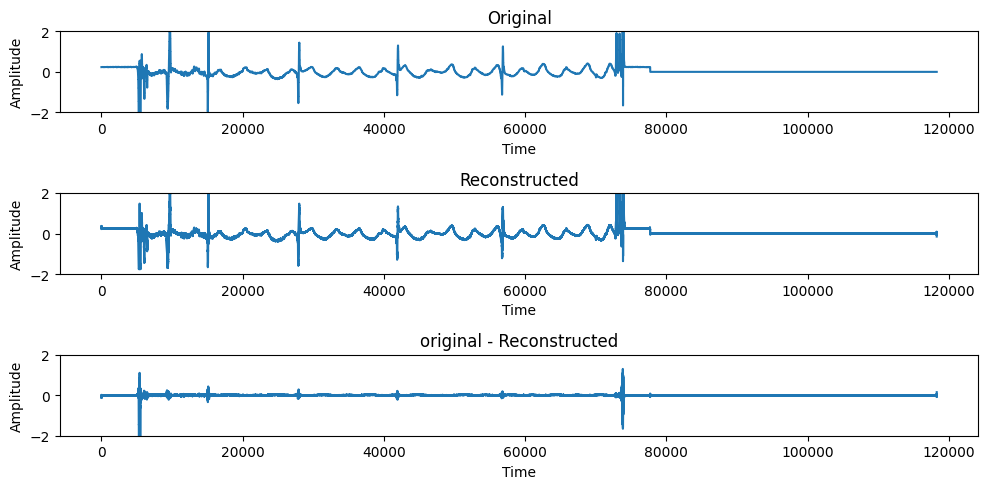

In [12]:
# 学習データを使って再構築を行う
reconstructed_data = autoencoder.predict(padded_sensor_data)

n = 5  # 表示するデータ
plt.figure(figsize=(10, 5))

# オリジナルのデータをプロット
ax = plt.subplot(3, 1, 1)
plt.plot(padded_sensor_data[n])
plt.title("Original")
plt.ylim(-2,2)
plt.xlabel('Time')  # x軸ラベル
plt.ylabel('Amplitude')  # y軸ラベル

# 再構築されたデータをプロット
ax = plt.subplot(3, 1, 2)
plt.plot(reconstructed_data[n])
plt.title("Reconstructed")
plt.ylim(-2,2)
plt.xlabel('Time')  # x軸ラベル
plt.ylabel('Amplitude')  # y軸ラベル

# オリジナル-再構築
ax = plt.subplot(3, 1, 3)
plt.plot(padded_sensor_data[n] - reconstructed_data[n])
plt.title("original - Reconstructed")
plt.ylim(-2,2)
plt.xlabel('Time')  # x軸ラベル
plt.ylabel('Amplitude')  # y軸ラベル

plt.tight_layout()
plt.show()


In [13]:
# テストデータの異常度スコアを計算
predictions = autoencoder.predict(padded_test_sensor_data)  # テストデータをモデルに入力して再構成
mse = np.mean(np.square(padded_test_sensor_data - predictions), axis=(1, 2))  # テストデータと再構成データの平均二乗誤差を計算

226/226 [==============================] - 4s 17ms/step


In [20]:
# 異常度の閾値を設定
threshold = 0.35
# 異常と判断されたデータのインデックスを取得
anomalies_idx = np.where(mse > threshold)[0]
print("異常と判断されたデータのインデックス:", anomalies_idx)

異常と判断されたデータのインデックス: [   3   65   67   69   81   83   89   91  100  123  145  147  149  163
  169  171  173  177  179  181  193  195  197  201  203  205  257  259
  261  265  267  289  291  293  313  315  317  345  347  369  371  373
  491  505  507  509  521  523  525  587  609  611  613  657  659  689
  691  693  713  715  717  721  723  725  785  787  789  817  819  833
  835  883  885  905  907  909  913  915  917  931  971  973  977  979
  981 1001 1003 1005 1035 1051 1065 1067 1069 1073 1075 1077 1113 1115
 1117 1131 1137 1139 1141 1177 1179 1249 1251 1253 1257 1259 1261 1265
 1267 1269 1273 1275 1277 1345 1347 1349 1393 1395 1397 1409 1411 1413
 1417 1419 1421 1448 1450 1452 1540 1561 1563 1565 1593 1595 1597 1693
 1729 1731 1733 2076 2104 2106 2108 2136 2138 2140 2265 2267 2269 2419
 3307 3323 3331 3388 3472 3474 3476 3489 3491 3504 3506 3508 3532 3600
 3602 3604 3697 3699 3969 3971 3973 4024 4028 4060 4107 4153 4155 4157
 4163 4177 4179 4181 4192 4194 4196 4217 4219 4221 4268 4

In [29]:
# 異常と判断されたデータのインデックスから対応するデータのフルパス（dictのキー）を取得
anomalies_paths = [list(test_sensor_data_dict.keys())[idx] for idx in anomalies_idx]
#print("異常と判断されたデータのフルパス:", anomalies_paths)
# 異常と判断されたデータのフルパスをDataFrameに追加
data = {'異常と判断されたデータのフルパス': anomalies_paths}
df = pd.DataFrame(data)

# Excelファイルに書き出し
df.to_excel('SWWAE_ET_1.xlsx', index=False)

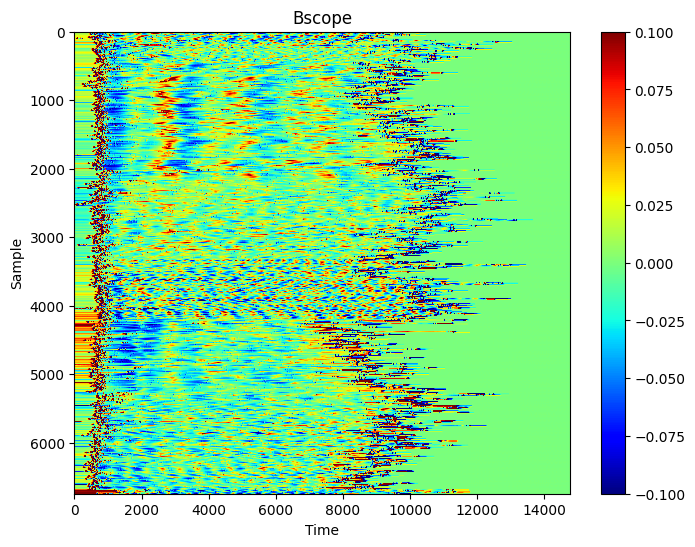

In [38]:
plt.figure(figsize=(8, 6))
a = padded_sensor_data.reshape((int(len(sensor_data)),max_length))
plt.imshow(a, aspect='auto', cmap='jet', vmin=-0.1, vmax=0.1)  # vminとvmaxで表示範囲を指定
#plt.imshow(a[6680:6690,:], aspect='auto', cmap='jet', vmin=-0.2, vmax=0.2)  # vminとvmaxで表示範囲を指定

plt.colorbar()  #カラーバーを表示
plt.title('Bscope')
plt.xlabel('Time')
plt.ylabel('Sample')
plt.show()

In [12]:
whos

Variable                           Type        Data/Info
--------------------------------------------------------
Adam                               type        <class 'keras.optimizers.optimizer_v2.adam.Adam'>
Conv1D                             type        <class 'keras.layers.conv<...>olutional.conv1d.Conv1D'>
Conv1DTranspose                    type        <class 'keras.layers.conv<...>anspose.Conv1DTranspose'>
Input                              function    <function Input at 0x0000015F4C71D480>
MaxPooling1D                       type        <class 'keras.layers.pool<...>_pooling1d.MaxPooling1D'>
Model                              type        <class 'keras.engine.training.Model'>
StandardScaler                     type        <class 'sklearn.preproces<...>ng._data.StandardScaler'>
UpSampling1D                       type        <class 'keras.layers.resh<...>sampling1d.UpSampling1D'>
data                               dict        n=843
data_filenames                     list        n=9

In [42]:
# モデルを保存
autoencoder.save("model\\1120autoencoder_model.h5")

In [ ]:
from tensorflow.keras.models import load_model

# モデルを読み込む
loaded_model = load_model("model\\autoencoder_model.h5")

In [11]:
# 画像として保存
plt.savefig('training_loss.png')  # 任意のファイル名と拡張子を指定して保存

<Figure size 640x480 with 0 Axes>

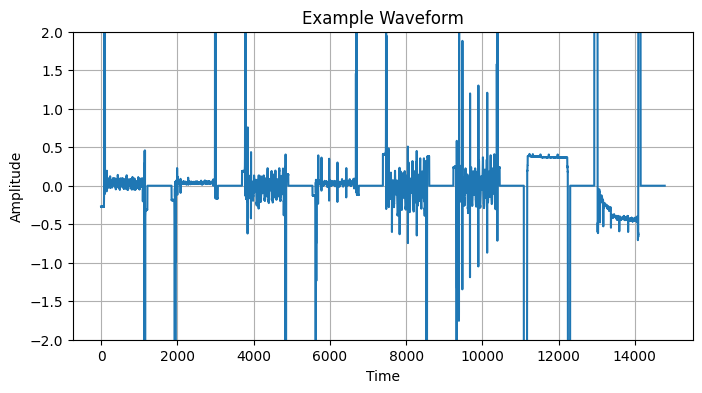

In [10]:
# 例として最初のセンサーの最初の波形をプロットする
plt.figure(figsize=(8, 4))
plt.plot(padded_sensor_data[0,:,0])  # 最初のセンサー、最初の波形をプロット

plt.xlabel('Time')  # x軸ラベル
plt.ylabel('Amplitude')  # y軸ラベル
plt.title('Example Waveform')  # グラフのタイトル
plt.ylim(-2,2)
plt.grid(True)  # グリッドを表示
plt.show()  # グラフを表示

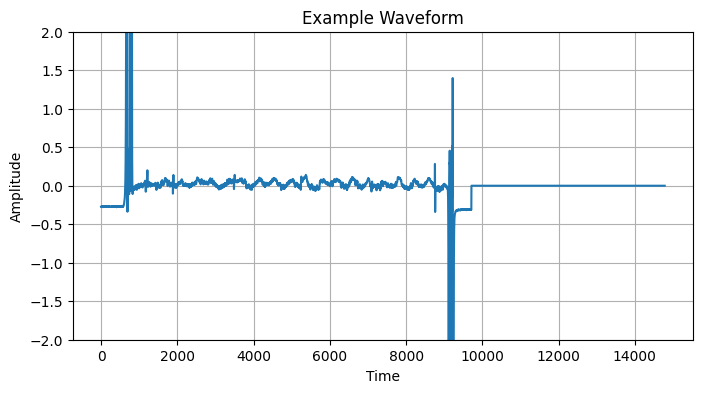

In [25]:
plt.figure(figsize=(8, 4))
plt.plot(padded_sensor_data[0,:])  # 最初のセンサー、最初の波形をプロット

plt.xlabel('Time')  # x軸ラベル
plt.ylabel('Amplitude')  # y軸ラベル
plt.title('Example Waveform')  # グラフのタイトル
plt.ylim(-2,2)
plt.grid(True)  # グリッドを表示
plt.show()  # グラフを表示

In [7]:
whos

Variable                           Type        Data/Info
--------------------------------------------------------
Adam                               type        <class 'keras.optimizers.optimizer_v2.adam.Adam'>
Conv1D                             type        <class 'keras.layers.conv<...>olutional.conv1d.Conv1D'>
Conv1DTranspose                    type        <class 'keras.layers.conv<...>anspose.Conv1DTranspose'>
Input                              function    <function Input at 0x0000015F4C71D480>
MaxPooling1D                       type        <class 'keras.layers.pool<...>_pooling1d.MaxPooling1D'>
Model                              type        <class 'keras.engine.training.Model'>
StandardScaler                     type        <class 'sklearn.preproces<...>ng._data.StandardScaler'>
UpSampling1D                       type        <class 'keras.layers.resh<...>sampling1d.UpSampling1D'>
data                               dict        n=843
data_filenames                     list        n=9

In [33]:
padded_test_sensor_data = np.stack((padded_test_sensor_data, padded_test_sensor_data), axis=-1)

In [19]:
input_shape

(14784,)